# Implementation: Medium Design a Movie Recommendation System with using Graph Database (neo4j) — part 1

- link:https://medium.com/@yesilliali/design-a-movie-recommendation-system-with-using-graph-database-neo4j-part-1-2c4933f4da0a

## preview data 

In [50]:
import os 
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
os.listdir('./data')

['links.csv',
 'tags.csv',
 'genome-tags.csv',
 'ratings.csv',
 'README.txt',
 'genome-scores.csv',
 'movies.csv']

In [3]:
genome_scores_data = pd.read_csv('./data/genome-scores.csv') 
movies_data = pd.read_csv('./data/movies.csv') 
ratings_data = pd.read_csv('./data/ratings.csv')

In [4]:
genome_scores_data.head(3)

,movieId,tagId,relevance
0,1,1,0.02875
1,1,2,0.02375
2,1,3,0.06250


In [5]:
genome_scores_data.groupby('movieId')['tagId'].nunique().reset_index()


,movieId,tagId
0,1,1128
1,2,1128
2,3,1128
3,4,1128
4,5,1128
...,...,...
13811,205072,1128
13812,205076,1128
13813,205383,1128
13814,205425,1128


In [6]:
genome_scores_data[genome_scores_data['movieId'] == 1]

,movieId,tagId,relevance
0,1,1,0.02875
1,1,2,0.02375
2,1,3,0.06250
3,1,4,0.07575
4,1,5,0.14075
...,...,...,...
1123,1,1124,0.05775
1124,1,1125,0.03900
1125,1,1126,0.02975
1126,1,1127,0.08475


In [7]:
genome_scores_data[genome_scores_data['movieId'] == 2]

,movieId,tagId,relevance
1128,2,1,0.04125
1129,2,2,0.04050
1130,2,3,0.06275
1131,2,4,0.08275
1132,2,5,0.09100
...,...,...,...
2251,2,1124,0.03275
2252,2,1125,0.02100
2253,2,1126,0.01100
2254,2,1127,0.10525


In [8]:
movies_data

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy
...,...,...,...
62418,209157,We (2018),Drama
62419,209159,Window of the Soul (2001),Documentary
62420,209163,Bad Poems (2018),Comedy|Drama
62421,209169,A Girl Thing (2001),(no genres listed)


In [9]:
ratings_data

,userId,movieId,rating,timestamp
0,1,296,5.0,1147880044
1,1,306,3.5,1147868817
2,1,307,5.0,1147868828
3,1,665,5.0,1147878820
4,1,899,3.5,1147868510
...,...,...,...,...
25000090,162541,50872,4.5,1240953372
25000091,162541,55768,2.5,1240951998
25000092,162541,56176,2.0,1240950697
25000093,162541,58559,4.0,1240953434


## preprocess for movie matrix

### genome_scores

-  For each `movieId`, there is a corresponding `relevance` value for each `tagId`, with a total of 1,128 `tagId`s.
- The current format shows one `movieId` and one `tagId` per row. We need to transform it so each row represents one `movieId` with relevance values for all 1,128 `tagId`s.

In [10]:
genome_scores_data.groupby('movieId')['tagId'].nunique().reset_index()

,movieId,tagId
0,1,1128
1,2,1128
2,3,1128
3,4,1128
4,5,1128
...,...,...
13811,205072,1128
13812,205076,1128
13813,205383,1128
13814,205425,1128


In [13]:
genome_scores_data

,movieId,tagId,relevance
0,1,1,0.02875
1,1,2,0.02375
2,1,3,0.06250
3,1,4,0.07575
4,1,5,0.14075
...,...,...,...
15584443,206499,1124,0.11000
15584444,206499,1125,0.04850
15584445,206499,1126,0.01325
15584446,206499,1127,0.14025


In [14]:
genome_scores_data = genome_scores_data.pivot(index=['movieId'], columns=['tagId'], values='relevance').reset_index()
genome_scores_data.head(3)
# scores_pivot = genome_scores_data.pivot_table(index = ["movieId"],columns = ["tagId"],values = "relevance").reset_index()


tagId,movieId,1,2,3,4,5,6,7,8,9,...,1119,1120,1121,1122,1123,1124,1125,1126,1127,1128
0,1,0.02875,0.02375,0.06250,0.07575,0.14075,0.14675,0.06350,0.20375,0.2020,...,0.04050,0.01425,0.03050,0.035,0.14125,0.05775,0.039,0.02975,0.08475,0.02200
1,2,0.04125,0.04050,0.06275,0.08275,0.09100,0.06125,0.06925,0.09600,0.0765,...,0.05250,0.01575,0.01250,0.020,0.12225,0.03275,0.021,0.01100,0.10525,0.01975
2,3,0.04675,0.05550,0.02925,0.08700,0.04750,0.04775,0.04600,0.14275,0.0285,...,0.06275,0.01950,0.02225,0.023,0.12200,0.03475,0.017,0.01800,0.09100,0.01775


### movies_data 

- process genres col, transfrom it to each row represents a single `movieId`, and the columns represent the `genres`. 

In [18]:
mov_genres_df = movies_data['genres'].str.get_dummies(sep='|')
mov_genres_df.insert(0, 'movieId', movies_data['movieId'])
mov_genres_df.drop(columns=['(no genres listed)'])

,movieId,Action,Adventure,Animation,Children,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,1,0,1,1,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0
1,2,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
2,3,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0
3,4,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0
4,5,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
62418,209157,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
62419,209159,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
62420,209163,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0
62421,209169,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [ ]:
mov_genres_df


,movieId,(no genres listed),Action,Adventure,Animation,Children,Comedy,Crime,Documentary,Drama,...,Film-Noir,Horror,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,1,0,0,1,1,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2,0,0,1,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,3,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,1,0,0,0,0
3,4,0,0,0,0,0,1,0,0,1,...,0,0,0,0,0,1,0,0,0,0
4,5,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
62418,209157,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
62419,209159,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
62420,209163,0,0,0,0,0,1,0,0,1,...,0,0,0,0,0,0,0,0,0,0
62421,209169,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### ratings_data

- first, extract the year from `title`, but note that some titles do not include parentheses and a year.

In [43]:
print(ratings_data.head(1))
print(movies_data.head(1))

   userId  movieId  rating   timestamp
0       1      296     5.0  1147880044
   movieId             title                                       genres
0        1  Toy Story (1995)  Adventure|Animation|Children|Comedy|Fantasy


In [44]:
title_list = movies_data['title'].tolist()

for i in title_list:
    if not '(' in i:
        print(i)

Terrible Joe Moran
The Court-Martial of Jackie Robinson
In Our Garden
Stephen Fry In America - New World
Two: The Story of Roman & Nyro
A Year Along the Abandoned Road
Body/Cialo
Polskie gówno
The Third Reich: The Rise & Fall
La vendetta dei barbari
My Own Man
Moving Alan
Zone 261
Michael Laudrup - en Fodboldspiller
Honky
Blueberry Hill
Pleasure Palace
Terror on the 40th Floor
My Boyfriend's Back
One Night Only
Doli Saja Ke Rakhna
The Dead Lands
C'mon, Let's Live a Little
For a Book of Dollars
Twins from Texas
Señorita Justice
Flash and Firecat
Red Victoria
Vaastupurush
Sierra Leone's Refugee All Stars
L'uomo della carità
The Big Fall
Wolves In The Snow
Amazon Falls
Dark Tides
The Ritual
The Expedition
Chinese Boxes
Danielův svět
The Near Room
Filmage: The Story of Descendents/All
About Sarah
La steppa
Swallows and Amazons
Ready Player One
Los tontos y los estúpidos
Ride in a Pink Car
Disaster Playground
Nice Guy
OMG, I'm a Robot!
KillerSaurus
Viva
Ollaan vapaita
Hyena Road
Asphalt Ang

In [47]:
def get_title_year(x):
    if '(' in x:
        return (x.split('(')[1])[0:-1]
    else:
        return np.nan

movies_data['title_year'] = movies_data['title'].apply(lambda x: get_title_year(x) )

In [49]:
movies_data.head(2)

,movieId,title,genres,title_year
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,1995
1,2,Jumanji (1995),Adventure|Children|Fantasy,1995


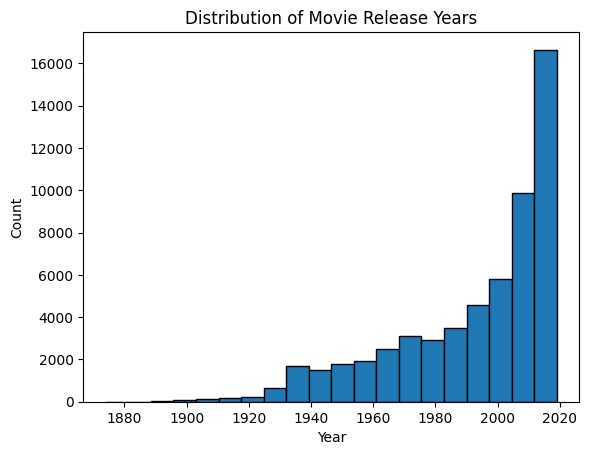

In [54]:
movies_data['title_year'].dropna().plot(
    kind='hist',
    bins=20,   
    edgecolor='black',
    title='Distribution of Movie Release Years'
)

plt.xlabel('Year')
plt.ylabel('Count')
plt.show()

In [59]:
print(movies_data['title_year'].min())
print(movies_data['title_year'].max())
print(movies_data['title_year'].median())

(2019.0-1874.0)/5

1874.0
2019.0
2002.0


29.0

In [ ]:
num_bins = 5 
bins = np.linspace(movies_data['title_year'].min(), movies_data['title_year'].max(), num_bins + 1)
movies_data['year_group'] = pd.cut(movies_data['title_year'], bins=bins, labels=range(1, num_bins + 1))
movies_data['year_group'] = movies_data['year_group'].cat.add_categories([0]).fillna(0)
movies_data.head(10)

,movieId,title,genres,title_year,year_group
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,1995.0,5
1,2,Jumanji (1995),Adventure|Children|Fantasy,1995.0,5
2,3,Grumpier Old Men (1995),Comedy|Romance,1995.0,5
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance,1995.0,5
4,5,Father of the Bride Part II (1995),Comedy,1995.0,5
5,6,Heat (1995),Action|Crime|Thriller,1995.0,5
6,7,Sabrina (1995),Comedy|Romance,1995.0,5
7,8,Tom and Huck (1995),Adventure|Children,1995.0,5
8,9,Sudden Death (1995),Action,1995.0,5
9,10,GoldenEye (1995),Action|Adventure|Thriller,1995.0,5


In [66]:
movies_data[movies_data['title_year'].isna()]

,movieId,title,genres,title_year,year_group
28,29,"City of Lost Children, The (Cité des enfants p...",Adventure|Drama|Fantasy|Mystery|Sci-Fi,NaN,0
29,30,Shanghai Triad (Yao a yao yao dao waipo qiao) ...,Crime|Drama,NaN,0
31,32,Twelve Monkeys (a.k.a. 12 Monkeys) (1995),Mystery|Sci-Fi|Thriller,NaN,0
46,47,Seven (a.k.a. Se7en) (1995),Mystery|Thriller,NaN,0
57,58,"Postman, The (Postino, Il) (1994)",Comedy|Drama|Romance,NaN,0
...,...,...,...,...,...
62292,208613,Untitled (A Film) (2017),Thriller,NaN,0
62326,208763,Yosemite: The Fate of Heaven,(no genres listed),NaN,0
62369,208917,Caicedo (with Pole) (1894),Documentary,NaN,0
62380,208973,The Falklands War: The Untold Story,(no genres listed),NaN,0
